In [1]:
import os
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random
import tensorflow.keras as keras

# configure notebook to display plots
%matplotlib inline

# set up user paths
data_dir = 'E:/Subjects/Neural/Modelling_Time_series_data/data/'
csv_dir = 'E:/Subjects/Neural/Modelling_Time_series_data/csv/'

In [2]:
# Fetch the DataFrame's loaded in the problem setup
X_train=pd.read_pickle('X_train.pkl')
y_train=pd.read_pickle('y_train.pkl')
X_valid=pd.read_pickle('X_valid.pkl')
y_valid=pd.read_pickle('y_valid.pkl')

In [3]:
# Before normalization
X_train.loc[8,['Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)']]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.573383,107.0,100.0,25.0,NaN,NaN,19.0,NaN,NaN
0.250000,7.573411,98.0,100.0,NaN,NaN,NaN,31.0,NaN,NaN
0.500000,7.573440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,7.573450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750000,7.573468,103.0,100.0,NaN,130.0,92.0,37.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...
150.500000,7.590551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150.750000,7.590580,94.0,100.0,25.0,121.0,88.0,14.0,6.0,2.0
150.766663,7.590582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# create file path for csv file with metadata about variables
metadata = os.path.join(csv_dir, 'ehr_features.csv')

# read in variables from csv file (using pandas) since each varable there is tagged with a category
variables = pd.read_csv(metadata, index_col=0)

# next, select only variables of a particular category for normalization
normvars = variables[variables['type'].isin(['Interventions', 'Labs', 'Vitals'])]

# finally, iterate over each variable in both training and validation data
for vId, dat in normvars.iterrows():
    
    X_train[vId] = X_train[vId] - dat['mean']
    X_valid[vId] = X_valid[vId] - dat['mean']
    X_train[vId] = X_train[vId] / (dat['std'] + 1e-12)
    X_valid[vId] = X_valid[vId] / (dat['std'] + 1e-12)
    

In [5]:
# After normalization
X_train.loc[8,['Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)']]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,7.573383,-0.429630,0.805317,-10.577633,NaN,NaN,-0.928604,NaN,NaN
0.250000,7.573411,-0.986894,0.805317,NaN,NaN,NaN,1.122353,NaN,NaN
0.500000,7.573440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,7.573450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.750000,7.573468,-0.677303,0.805317,NaN,2.087398,3.242043,2.147832,1.240359,2.887591
...,...,...,...,...,...,...,...,...,...
150.500000,7.590551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150.750000,7.590580,-1.234567,0.805317,-10.577633,1.305183,2.874280,-1.783170,1.240359,-1.101130
150.766663,7.590582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


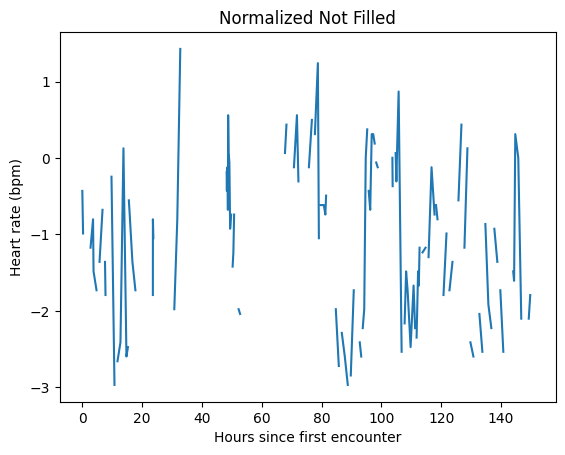

In [6]:
# Before filling gaps
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized Not Filled")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

In [7]:
# first select variables which will be filled in
fillvars = variables[variables['type'].isin(['Vitals', 'Labs'])].index

# next forward fill any missing values with more recently observed value
X_train[fillvars] = X_train.groupby(level=0)[fillvars].ffill()
X_valid[fillvars] = X_valid.groupby(level=0)[fillvars].ffill()

# finally, fill in any still missing values with 0 (i.e. values that could not be filled forward)
X_train.fillna(value=0, inplace=True)
X_valid.fillna(value=0, inplace=True)

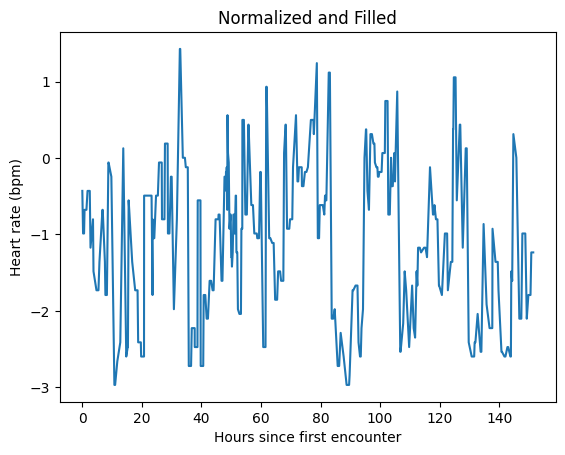

In [8]:
# After filling gaps
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized and Filled")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

In [9]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                     0.000000  0.000000          0.000000   
            0.250000                     0.000000  0.000000          0.000000   
            0.500000                     0.000000  0.000000          0.000000   
            0.583333                     0.000000  0.000000          0.000000   
            0.750000                     0.000000  0.000000          0.000000   
...                                           ...       ...               ...   
16259       87.000000                    2.335037 -1.770313          2.569377   
            87.083336                    2.335037 -1.770313          2.569377   
            87.666664                    2.335037 -1.770313          2.569377   
            88.000000                    2.335037 -1.770313          2.569377   
            89.000000                    2.335037 -1.770313          2.569377   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000            0.000000         0.000000          0.0000   
            0.250000            0.000000         0.000000          0.0000   
            0.500000            0.000000         0.000000          0.0000   
            0.583333            0.000000         0.000000          0.0000   
            0.750000            0.000000         0.000000          0.0000   
...                                  ...              ...             ...   
16259       87.000000          -2.668261         0.925765         -1.7796   
            87.083336          -2.668261         0.925765         -1.7796   
            87.666664          -2.668261         0.925765         -1.7796   
            88.000000          -2.668261         0.925765         -1.7796   
            89.000000          -2.668261         0.925765         -1.7796   

                          ABG TCO2 (mEq/L)    ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                     
8           0.000000              0.000000  0.000000                   0.0   
            0.250000              0.000000  0.000000                   0.0   
            0.500000              0.000000  0.000000                   0.0   
            0.583333              0.000000  0.000000                   0.0   
            0.750000              0.000000  0.000000                   0.0   
...                                    ...       ...                   ...   
16259       87.000000             2.385686  0.845536                   0.0   
            87.083336             2.385686  0.845536                   0.0   
            87.666664             2.385686  0.845536                   0.0   
            88.000000             2.385686  0.845536                   0.0   
            89.000000             2.385686  0.845536                   0.0   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       0.0  ...          0.0         0.0   
            0.250000                       0.0  ...          0.0         0.0   
            0.500000                       0.0  ...          0.0         0.0   
            0.583333                       0.0  ...          0.0         0.0   
            0.750000                       0.0  ...          0.0         0.0   
...                                        ...  ...          ...         ...   
16259       87.000000                      0.0  ...          0.0         0.0   
            87.083336                      0.0  ...          0.0         0.0   
            87.666664                      0.0  ...          0.0         0.0   
            88.000000                      0.0  ...          0.0         0.

In [10]:
type(X_train)

pandas.core.frame.DataFrame

In [11]:
from tensorflow.keras.preprocessing import sequence

# max number of sequence length
maxlen = 500

# get a list of unique patient encounter IDs
teId = X_train.index.levels[0]
veId = X_valid.index.levels[0]

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [X_train.loc[patient].values for patient in teId]
y_train = [y_train.loc[patient].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [X_valid.loc[patient].values for patient in veId]
y_valid = [y_valid.loc[patient].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

Okay, a lot just happened here:  

1. We converted the _pandas_ DataFrame into a Python list, which contained lists of values (a list of list of values).  
2. Using  `keras.preprocessing.sequence.pad_sequences`, we converted the value lists into a `numpy.array` of type `float32`, having a maximum length of 500.  
3. If the patient encounter didn't have 500 encounters (most don't, see previous histogram) then we apply `padding='post'`, which says to pad with zeros.  That is, add extra rows (observation vectors) of all zeros.
4. The option `truncating='post'` just says: if there are more than 500 observations, then take the first 500 and drop everything after.  

Together, this says: **force patient encounter records of dimension 500x265 and use zero padding to inflate the size if needed**.  We could do something similar in _pandas_ but not as succinctly. This only requires a single command using _NumPy_.

In [12]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))

X_train shape: (5000, 500, 265) | y_train shape: (5000, 500, 1)
X_valid shape: (2690, 500, 265) | y_valid shape: (2690, 500, 1)


Note that the type of X_train has changed to ```numpy.ndarray```:

In [13]:
type(X_train)

numpy.ndarray

Now we can plot the full patient encounter as a matrix plot.  Try a few times to get a feel for what the charts look like.

ix = 2772


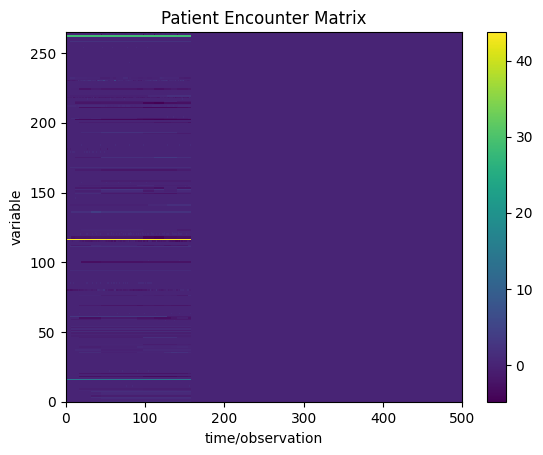

In [14]:
# figure out how many encounters we have
numencnt = X_train.shape[0]

# choose a random patient encounter to plot
ix = random.randint(0,5000) #Try a few different index values between 0 and 4999
print('ix = {}'.format(ix))

# plot a matrix of observation values
plt.title("Patient Encounter Matrix")
plt.pcolor(np.transpose(X_train[ix,:,:]))
plt.ylabel("variable")
plt.xlabel("time/observation")
plt.ylim(0,265)
plt.colorbar()
plt.show()

In [17]:
# Save the prepared numpy arrays for use in other notebooks
np.save('X_train_prepared.npy',X_train,allow_pickle=False)
np.save('y_train_prepared.npy',y_train,allow_pickle=False)
np.save('X_valid_prepared.npy',X_valid,allow_pickle=False)
np.save('y_valid_prepared.npy',y_valid,allow_pickle=False)

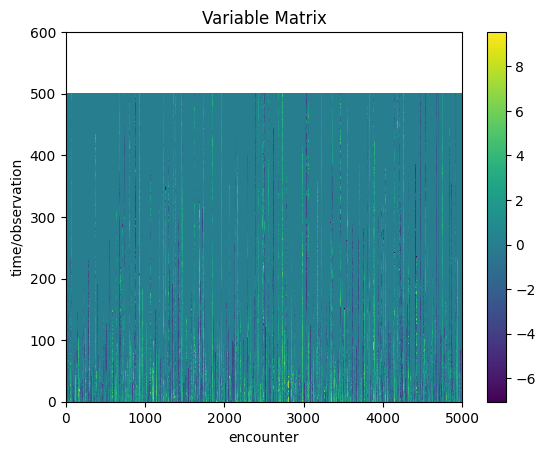

In [18]:
# TODO Step 1 set the variable value (feature number)
varnum = 115 #FIXME  (any number between 0 and 264, inclusive)

# TODO Step 2 Create a matrix of encounters vs time/observation
# Hint: Select along the 3rd axis
varmatrix = np.transpose(X_train[:,:,varnum])  #FIXME

# Step 3 Plot the matrix
try:
    plt.title("Variable Matrix")
    plt.pcolor(varmatrix) 
    plt.ylabel("time/observation")
    plt.xlabel("encounter")
    plt.ylim(0,600)
    plt.colorbar()
    plt.show()
except Exception as e:
    print('ERROR found: {}'.format(e))